### Spis Treści
1. [Biblioteki](#Biblioteki)
2. [Ścieżki do obrazów](#Ścieżki-do-obrazów)
3. [Przygotowanie zdjęć do klasyfikacji](#Przygotowanie-zdjęć-do-klasyfikacji)
4. [Implementacja własnego modelu klasyfikacyjnego](#Implementacja-własnego-modelu-klasyfikacyjnego)
5. [Wykorzystanie sieci DenseNet121 (Model Fine-Tuning)](#Wykorzystanie-sieci-DenseNet121-(Model-Fine-Tuning))
6. [Ocena jakości modelu](#Ocena-jakości-modelu)

---

## Fragment kodu do pracy w Google Colab

In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Rozpakowanie danych do folderu na dysku Google (należy utworzyć folder "Projekt DL" i tam umieścić zip)
#!unzip '/content/drive/My Drive/Projekt DL/Train_Test_Split.zip' -d '/content/drive/My Drive/Projekt DL'

In [2]:
train_path = '/content/drive/My Drive/Projekt DL/Train_Test_Split/Train'
test_path = '/content/drive/My Drive/Projekt DL/Train_Test_Split/Test'
val_path = '/content/drive/My Drive/Projekt DL/Train_Test_Split/Validation'

---

## Biblioteki

In [8]:
# Podstawowe
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image

# Do obróbki danych
from sklearn.model_selection import train_test_split, GridSearchCV
from keras.preprocessing.image import ImageDataGenerator

# Do DL
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, Dense
from keras.utils import plot_model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import r2_score, f1_score, precision_score, recall_score, roc_auc_score, classification_report

from keras.applications.densenet import DenseNet121
from keras.applications.vgg16 import VGG16

#Zmienienie formatu zapisu danych numerycznych na dwie cyfry po przecinku.
pd.options.display.float_format = '{:.2f}'.format

## Ścieżki do obrazów
W tym miejscu należy zmienić ścieżki według tego gdzie znajdują się foldery z obrazami, które utworzyliśmy za pomocą tego skryptu: [skrypt.ipynb](https://github.com/infoshareacademy/jdszr13-python_dynamites/blob/szymoncyranowicz/projekt_dl/skrypt.ipynb). Jeżeli robicie w Google Colab to nie uruchamiajcie tej komórki.

In [2]:
train_path = "PetImages\Train_Test_Split\Train"
test_path = "PetImages\Train_Test_Split\Test"
val_path = "PetImages\Train_Test_Split\Validation"

## Przygotowanie zdjęć do klasyfikacji

In [ ]:
#Usunięcie problematycznych zdjęć https://www.kaggle.com/datasets/shaunthesheep/microsoft-catsvsdogs-dataset/discussion/438473
#os.remove(os.path.join(train_path, 'cat', '666.jpg'))
#os.remove(os.path.join(val_path, 'dog', '11702.jpg'))

In [3]:
train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20, # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.1, # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1, # randomly shift images vertically (fraction of total height)
    shear_range=0.1,
    zoom_range=0.1, # Randomly zoom image
    horizontal_flip=True, # randomly flip images
    vertical_flip=True,  # randomly flip images
    fill_mode='nearest')

test_gen = ImageDataGenerator(rescale=1./255)

In [4]:
train = train_gen.flow_from_directory(
    train_path,
    batch_size=20,
    shuffle=True,
    class_mode='binary',
    target_size=(224, 224))

test = test_gen.flow_from_directory(
    test_path,
    batch_size=20,
    shuffle=False,
    class_mode='binary',
    target_size=(224, 224))

val = test_gen.flow_from_directory(
    val_path,
    batch_size=20,
    shuffle=False,
    class_mode='binary',
    target_size=(224, 224))

Found 12999 images belonging to 2 classes.
Found 6000 images belonging to 2 classes.
Found 5999 images belonging to 2 classes.


## Podgląd zdjęć po obróbce

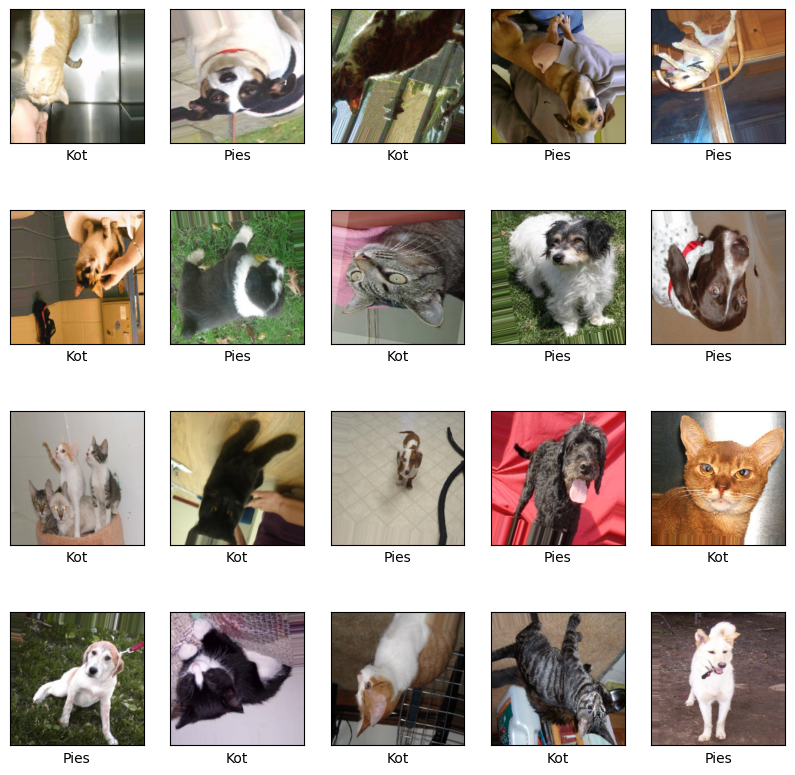

In [5]:
img, label = train.__getitem__(0)

plt.figure(figsize=(10,10))
for i in range(20):
    plt.subplot(4,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(img[i])
    plt.xlabel("Pies" if label[i] == 1 else "Kot")
plt.show()

## Implementacja własnego modelu klasyfikacyjnego

In [6]:
METRICS = ['accuracy',
           tf.keras.metrics.Precision(name='precision'),
           tf.keras.metrics.Recall(name='recall'),
           tf.keras.metrics.AUC(name='AUC')]

adam_001 = tf.keras.optimizers.legacy.Adam(learning_rate=0.001)

earlystop = EarlyStopping(patience = 10)
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_accuracy', patience = 2, verbose = 1, factor = 0.5, min_lr = 0.00001)
callbacks = [earlystop, learning_rate_reduction]

In [ ]:
our_model = Sequential([

    Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3)),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Dropout(0.25),

    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Dropout(0.25),

    Conv2D(128, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Dropout(0.25),

    Flatten(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.25),
    Dense(1, activation='sigmoid')
])

our_model.compile(optimizer=adam_001, loss='binary_crossentropy', metrics = METRICS)
print(our_model.summary())

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 batch_normalization_24 (Ba  (None, 222, 222, 32)      128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_18 (MaxPooli  (None, 111, 111, 32)      0         
 ng2D)                                                           
                                                                 
 dropout_26 (Dropout)        (None, 111, 111, 32)      0         
                                                                 
 conv2d_19 (Conv2D)          (None, 109, 109, 64)      18496     
                                                                 
 batch_normalization_25 (Ba  (None, 109, 109, 64)     

In [ ]:
t_history = our_model.fit(
    train,
    epochs = 30,
    validation_data = val,
    steps_per_epoch = 300,
    validation_steps = 20,
    callbacks = callbacks)

Epoch 1/30
300/300 [==============================] - 104s 342ms/step - loss: 0.8174 - accuracy: 0.5785 - precision: 0.5749 - recall: 0.5700 - AUC: 0.6100 - val_loss: 0.1333 - val_accuracy: 0.9975 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_AUC: 0.0000e+00 - lr: 0.0010
Epoch 2/30
300/300 [==============================] - 105s 351ms/step - loss: 0.6675 - accuracy: 0.6231 - precision: 0.6266 - recall: 0.6051 - AUC: 0.6770 - val_loss: 0.5511 - val_accuracy: 0.7675 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_AUC: 0.0000e+00 - lr: 0.0010
Epoch 3/30
300/300 [==============================] - ETA: 0s - loss: 0.6212 - accuracy: 0.6503 - precision: 0.6581 - recall: 0.6257 - AUC: 0.7149
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
300/300 [==============================] - 107s 355ms/step - loss: 0.6212 - accuracy: 0.6503 - precision: 0.6581 - recall: 0.6257 - AUC: 0.7149 - val_loss: 0.7166 - val_accuracy: 0.6150 - val_precision: 0.00

## Wykorzystanie sieci DenseNet121 (Model Fine-Tuning)

In [7]:
dense_base_model = DenseNet121(input_shape=(244, 244, 3),
                               pooling = 'avg',
                               include_top=False,
                               weights='imagenet')

dense_model = tf.keras.Sequential([
        dense_base_model,
        Flatten(),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(1, activation="sigmoid")])

dense_model.compile(loss='binary_crossentropy',
                  optimizer = adam_001,
                  metrics = METRICS)

29084464/29084464 [==============================] - 2s 0us/step


In [8]:
dense_history = dense_model.fit(
    train,
    epochs = 10,
    validation_data = val,
    steps_per_epoch = 300,
    validation_steps = 20,
    callbacks = callbacks,
    )

Epoch 1/10
300/300 [==============================] - 1253s 4s/step - loss: 0.4357 - accuracy: 0.8043 - precision: 0.8069 - recall: 0.8015 - AUC: 0.8862 - val_loss: 3.0725 - val_accuracy: 0.6275 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_AUC: 0.0000e+00 - lr: 0.0010
Epoch 2/10
300/300 [==============================] - 1243s 4s/step - loss: 0.3434 - accuracy: 0.8546 - precision: 0.8437 - recall: 0.8728 - AUC: 0.9301 - val_loss: 1.1965 - val_accuracy: 0.6825 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_AUC: 0.0000e+00 - lr: 0.0010
Epoch 3/10
300/300 [==============================] - 1263s 4s/step - loss: 0.3206 - accuracy: 0.8702 - precision: 0.8654 - recall: 0.8715 - AUC: 0.9387 - val_loss: 0.0507 - val_accuracy: 0.9975 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_AUC: 0.0000e+00 - lr: 0.0010
Epoch 4/10
300/300 [==============================] - 1250s 4s/step - loss: 0.2909 - accuracy: 0.8805 - precision: 0.8757 - recall: 0.8871 - AUC: 0.949

In [17]:
dense_model.save('dense_model_10ep.keras')

In [18]:
dense_history = dense_model.fit(
    train,
    epochs = 2,
    validation_data = val,
    steps_per_epoch = 300,
    validation_steps = 20,
    callbacks = callbacks,
    )

Epoch 1/2
300/300 [==============================] - 1292s 4s/step - loss: 0.1047 - accuracy: 0.9622 - precision: 0.9590 - recall: 0.9663 - AUC: 0.9921 - val_loss: 0.1064 - val_accuracy: 0.9525 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_AUC: 0.0000e+00 - lr: 1.2500e-04
Epoch 2/2
300/300 [==============================] - 1295s 4s/step - loss: 0.0997 - accuracy: 0.9633 - precision: 0.9576 - recall: 0.9691 - AUC: 0.9936 - val_loss: 0.0937 - val_accuracy: 0.9650 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_AUC: 0.0000e+00 - lr: 1.2500e-04


In [20]:
dense_model.save('dense_model_12ep.h5')

## Ocena jakości modelu

In [11]:
# Ścieżka do zapisanego modelu
model_path = 'dense_model_12ep.h5'

# Wczytanie modelu
dense_model_saved = load_model(model_path)

test_dense_evaluation = dense_model_saved.evaluate(test)

print(f"Test Accuracy: {test_dense_evaluation[1]:.4f}")
print(f"Test Precision: {test_dense_evaluation[2]:.4f}")
print(f"Test Recall: {test_dense_evaluation[3]:.4f}")
print(f"Test AUC: {test_dense_evaluation[4]:.4f}")

train_dense_evaluation = dense_model_saved.evaluate(train)

print(f"Train Accuracy: {train_dense_evaluation[1]:.4f}")
print(f"Train Precision: {train_dense_evaluation[2]:.4f}")
print(f"Train Recall: {train_dense_evaluation[3]:.4f}")
print(f"Train AUC: {train_dense_evaluation[4]:.4f}")

val_dense_evaluation = dense_model_saved.evaluate(val)

print(f"Val Accuracy: {val_dense_evaluation[1]:.4f}")
print(f"Val Precision: {val_dense_evaluation[2]:.4f}")
print(f"Val Recall: {val_dense_evaluation[3]:.4f}")
print(f"Val AUC: {val_dense_evaluation[4]:.4f}")

300/300 [==============================] - 266s 881ms/step - loss: 0.0882 - accuracy: 0.9647 - precision: 0.9681 - recall: 0.9610 - AUC: 0.9952
Test Accuracy: 0.9647
Test Precision: 0.9681
Test Recall: 0.9610
Test AUC: 0.9952
650/650 [==============================] - 603s 928ms/step - loss: 0.0746 - accuracy: 0.9715 - precision: 0.9801 - recall: 0.9625 - AUC: 0.9970
Train Accuracy: 0.9715
Train Precision: 0.9801
Train Recall: 0.9625
Train AUC: 0.9970
300/300 [==============================] - 276s 919ms/step - loss: 0.0939 - accuracy: 0.9645 - precision: 0.9622 - recall: 0.9670 - AUC: 0.9938
Val Accuracy: 0.9645
Val Precision: 0.9622
Val Recall: 0.9670
Val AUC: 0.9938
